# Load neccessary libraries

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import time
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import db_utils as dbu 

# Initiate database connection

In [2]:
dbname    = 'mapd'
username  = 'mapd'
password  = 'HyperInteractive'
hostname  = 'localhost'
port      = 9091

client = dbu.get_client(hostname, port, False)
session = client.connect(username, password, dbname)


# Get data into the GPU

In [3]:
table_churn = "churn_telco_data"
query_churn = "SELECT * FROM {} ;".format(table_churn)
print('Query is : ' + query_churn)

tdf = client.sql_execute_gdf(session, query_churn, device_id=0, first_n=-1)

Query is : SELECT * FROM churn_telco_data ;


In [4]:
from pymapd._parsers import _parse_tdf_gpu
gdf = _parse_tdf_gpu(tdf)

Unfortunately at the moment it is not possible to use directly GPU dataframe for xgboost.

In [5]:
pd_df = gdf.to_pandas()
pd_df.head(5)

,State,AccountLength,AreaCode,Phone,IntlPlan,VMailPlan,VMailMessage,DayMins,DayCalls,DayCharge,...,EveCalls,EveCharge,NightMins,NightCalls,NightCharge,IntlMins,IntlCalls,IntlCharge,CustServCalls,Churn
0,MN,46,415,355-8887,no,no,0,214.100006,72,36.400002,...,104,13.97,177.500000,113,7.99,8.2,3,2.21,2,False.
1,CT,30,408,410-5192,no,no,0,137.600006,108,23.389999,...,80,13.77,187.699997,126,8.45,5.8,10,1.57,3,False.
2,AZ,137,415,370-4395,no,no,0,141.100006,91,23.990000,...,100,12.51,254.699997,75,11.46,8.0,7,2.16,2,False.
3,SC,22,408,331-5138,no,no,0,110.300003,107,18.750000,...,93,14.15,202.300003,96,9.10,9.5,5,2.57,0,False.
4,NM,103,415,417-6330,no,no,0,173.500000,83,29.500000,...,65,20.77,221.600006,66,9.97,9.7,2,2.62,3,False.


# Prepare data for xgboost
String columns have to be converted to numeric.


In [6]:

col_encoders = {}
for col in pd_df.columns[pd_df.dtypes == 'category']:
    label_encoder = LabelEncoder()
    col_encoders[col] = label_encoder.fit(pd_df[col])
    pd_df[col] = col_encoders[col].transform(pd_df[col])
    
pd_df.head(5)

,State,AccountLength,AreaCode,Phone,IntlPlan,VMailPlan,VMailMessage,DayMins,DayCalls,DayCharge,...,EveCalls,EveCharge,NightMins,NightCalls,NightCharge,IntlMins,IntlCalls,IntlCharge,CustServCalls,Churn
0,23,46,415,1037,0,0,0,214.100006,72,36.400002,...,104,13.97,177.500000,113,7.99,8.2,3,2.21,2,0
1,6,30,408,2939,0,0,0,137.600006,108,23.389999,...,80,13.77,187.699997,126,8.45,5.8,10,1.57,3,0
2,3,137,415,1532,0,0,0,141.100006,91,23.990000,...,100,12.51,254.699997,75,11.46,8.0,7,2.16,2,0
3,40,22,408,131,0,0,0,110.300003,107,18.750000,...,93,14.15,202.300003,96,9.10,9.5,5,2.57,0,0
4,32,103,415,3181,0,0,0,173.500000,83,29.500000,...,65,20.77,221.600006,66,9.97,9.7,2,2.62,3,0


## Remove unnecessary columns


In [7]:
y = pd_df['Churn'].values
del pd_df['Churn']
del pd_df['Phone']
#X = pd_df.values

# XGBoost

## Hyper-paramets

In [8]:
param = {}
param['objective'] = 'binary:logistic'
param['eval_metric'] = 'auc'
param['max_depth'] = 5
param['eta'] = 0.3
param['silent'] = 0
param['tree_method'] = 'gpu_exact'

num_round = 20

skf = StratifiedKFold(n_splits=5)

## Train

In [34]:
for i, (train, test) in enumerate(skf.split(pd_df, y)):
    dtrain = xgb.DMatrix(pd_df.iloc[train,:], label=y[train])
    tmp = time.time()
    bst = xgb.train(param, dtrain, num_round)
    boost_time = time.time() - tmp
    res = bst.eval(xgb.DMatrix(pd_df.iloc[test,:], label=y[test]))
    print("Fold {}: {}, Boost Time {}".format(i, res, str(boost_time)))
    #del bst

Fold 0: [0]	eval-auc:0.984303, Boost Time 0.10790443420410156
Fold 1: [0]	eval-auc:0.985353, Boost Time 0.11124348640441895
Fold 2: [0]	eval-auc:0.980084, Boost Time 0.10365962982177734
Fold 3: [0]	eval-auc:0.985443, Boost Time 0.10513448715209961
Fold 4: [0]	eval-auc:0.988737, Boost Time 0.10353565216064453


## Variable Importance

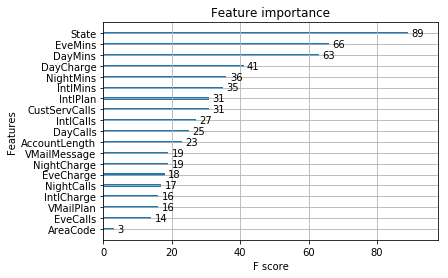

In [35]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(bst)
pyplot.show()

### Select top variable importance for grid creation

In [87]:
import operator
num_var = 4
varimp_dict = bst.get_fscore()
varimp = pd.DataFrame(sorted(varimp_dict.items(), key=operator.itemgetter(1), reverse=True))
varimp = varimp.iloc[0:num_var,]
varimp

,0,1
0,State,89
1,EveMins,66
2,DayMins,63
3,DayCharge,41


In [88]:

iterCol = 'State' # iterCol is used to break the data into chunks (in case data does not fit in memory)
gridCols = varimp[0].tolist()
excols = list(set(pd_df.columns) - set(gridCols))
gridCols = list(set(gridCols) - set([iterCol]))

print("iterate column:", iterCol)
print("grid columns:", gridCols)
print("excluded columns:", excols)

iterate column: State
grid columns: ['EveMins', 'DayMins', 'DayCharge']
excluded columns: ['VMailPlan', 'NightCalls', 'IntlCalls', 'CustServCalls', 'DayCalls', 'EveCharge', 'EveCalls', 'IntlPlan', 'AccountLength', 'NightCharge', 'IntlMins', 'IntlCharge', 'AreaCode', 'NightMins', 'VMailMessage']


### Create partial dependence grid

In [89]:
from sklearn.ensemble.partial_dependence import _grid_from_X

resolution = 20
df_grid = pd.DataFrame(_grid_from_X(pd_df[gridCols].values, grid_resolution=20)[0], columns=gridCols)
for col in excols:
    df_grid[col] = np.random.choice(pd_df[col].values, size=df_grid.shape[0], replace=True)

print("grid shape:", df_grid.shape)
df_grid.head(5)

grid shape: (8000, 18)


,EveMins,DayMins,DayCharge,VMailPlan,NightCalls,IntlCalls,CustServCalls,DayCalls,EveCharge,EveCalls,IntlPlan,AccountLength,NightCharge,IntlMins,IntlCharge,AreaCode,NightMins,VMailMessage
0,118.800003,89.800003,15.270000,0,107,2,2,105,19.690001,98,0,64,9.79,12.0,2.19,415,210.300003,0
1,118.800003,89.800003,16.889474,0,105,7,2,95,19.799999,100,0,48,10.08,10.6,2.35,415,254.399994,0
2,118.800003,89.800003,18.508948,0,111,1,2,97,17.590000,121,0,179,11.04,11.6,2.92,510,213.699997,0
3,118.800003,89.800003,20.128422,1,114,3,1,130,18.450001,103,0,132,7.26,14.1,3.27,415,182.399994,0
4,118.800003,89.800003,21.747895,0,127,3,4,123,21.570000,117,0,131,6.48,10.2,2.86,415,194.000000,0


### Calculate partial dependence predictions and save the results

In [90]:
fmt=['%.3f', '%.3f', '%.3f', '%.3f', '%.3f', '%i', '%i', '%i', '%i', 
     '%i', '%.3f', '%i', '%i', '%i', '%.3f', '%.3f', '%.3f', '%i', '%i', '%s']

iterVals = pd_df[iterCol].unique()
bst.set_param({"predictor":"cpu_predictor"})
for v in iterVals:   
    t0 = time.time()
    print("State: ", v)
    
    # Set all state value to v
    df_grid[iterCol] = v
    t1 = time.time()
    
    #Predict
    pred_p1 = bst.predict(xgb.DMatrix(df_grid[pd_df.columns]))
    t2 = time.time()
    print("Time to pred: ", (t2-t1))
    
    #Concat prediction probs with predictors
    tmp_df = pd.concat([pd.DataFrame(pred_p1, columns=["p1"]), df_grid], axis=1)
    t3 = time.time()
    print("Time to concat: ", (t3-t2))
    
    # Decode state values
    tmp_df['State'] = col_encoders['State'].inverse_transform(tmp_df['State'])
    t4 = time.time()
    print("Time to encode state col: ", (t4-t3))
    
    # Save results
    fname = './res/df_state-{}.csv'.format(col_encoders['State'].inverse_transform(v))
    np.savetxt(fname, tmp_df.values, fmt=fmt, delimiter=',')
    t5 = time.time()
    print("Time to save results: ", (t5-t4))
    
    print("Time to loop:", (t5-t0))

State:  23
Time to pred:  0.013698339462280273
Time to concat:  0.0037565231323242188
Time to encode state col:  0.0012409687042236328
Time to save results:  0.07023167610168457
Time to loop: 0.08983325958251953
State:  6
Time to pred:  0.0050847530364990234
Time to concat:  0.0033583641052246094
Time to encode state col:  0.0010309219360351562
Time to save results:  0.06959676742553711
Time to loop: 0.08007264137268066
State:  3
Time to pred:  0.005136966705322266
Time to concat:  0.0030786991119384766
Time to encode state col:  0.0012912750244140625
Time to save results:  0.07160639762878418
Time to loop: 0.08201813697814941
State:  40
Time to pred:  0.005204439163208008
Time to concat:  0.003490924835205078
Time to encode state col:  0.0011112689971923828
Time to save results:  0.06923222541809082
Time to loop: 0.08020544052124023
State:  32
Time to pred:  0.005204439163208008
Time to concat:  0.003358125686645508
Time to encode state col:  0.0010814666748046875
Time to save results

Time to save results:  0.07223987579345703
Time to loop: 0.08247542381286621
State:  0
Time to pred:  0.005152702331542969
Time to concat:  0.0033223628997802734
Time to encode state col:  0.0010848045349121094
Time to save results:  0.07169532775878906
Time to loop: 0.08196282386779785
State:  8
Time to pred:  0.005248308181762695
Time to concat:  0.0033032894134521484
Time to encode state col:  0.0010232925415039062
Time to save results:  0.0715782642364502
Time to loop: 0.08185815811157227
State:  21
Time to pred:  0.005219936370849609
Time to concat:  0.0032596588134765625
Time to encode state col:  0.0009627342224121094
Time to save results:  0.07176327705383301
Time to loop: 0.08192038536071777
State:  7
Time to pred:  0.005405902862548828
Time to concat:  0.0033066272735595703
Time to encode state col:  0.0010573863983154297
Time to save results:  0.07121753692626953
Time to loop: 0.08167290687561035
State:  17
Time to pred:  0.005231380462646484
Time to concat:  0.0033724308013

## Load the result into MapD database 

#### Create table for the results.

In [92]:
result_table_name = "churn_pd_results"
dbu.create_table_for(session, client, tmp_df, result_table_name)

Create query:  create table churn_pd_results ( p1 FLOAT, EveMins FLOAT, DayMins FLOAT, DayCharge FLOAT, VMailPlan INT, NightCalls INT, IntlCalls INT, CustServCalls INT, DayCalls INT, EveCharge FLOAT, EveCalls INT, IntlPlan INT, AccountLength INT, NightCharge FLOAT, IntlMins FLOAT, IntlCharge FLOAT, AreaCode INT, NightMins FLOAT, VMailMessage INT, State TEXT ); 


TQueryResult(nonce='', total_time_ms=20, execution_time_ms=11, row_set=TRowSet(rows=[], columns=[], row_desc=[], is_columnar=False))

#### Copy csv files into table:

In [107]:
wd = !pwd
copy_q = "COPY {} FROM '{}';".format(result_table_name, wd[0]+"/res/*")
client.sql_execute(session, copy_q, True, None, -1)

TQueryResult(nonce='', total_time_ms=3106, execution_time_ms=3098, row_set=TRowSet(rows=[], columns=[TColumn(data=TColumnData(int_col=[], str_col=['Loaded: 407949 recs, Rejected: 0 recs in 3.029000 secs'], arr_col=[], real_col=[]), nulls=[False])], row_desc=[TColumnType(is_reserved_keyword=False, col_name='Result', src_name='', col_type=TTypeInfo(is_array=False, comp_param=0, nullable=False, encoding=0, scale=0, precision=0, type=6))], is_columnar=True))